In [1]:
from typing import List, Dict, Any, Optional, Union

import urllib
import pandas as pd
import networkx as nx

from tqdm import tqdm
from time import time
from rdflib import Graph, URIRef, Literal, Namespace, URIRef
from pathlib import Path
from operator import itemgetter
from matplotlib import pyplot as plt
from collections import Counter
from rdflib.namespace import XSD, RDF, RDFS, SKOS

from rdflib.extras.external_graph_libs import *

**Note**: 
Visualizing the graph may improve our understanding of the data in the graph. **The IReC GitHub repository contains some instructions for visualizing the graph with GraphDB**. 

In this notebook, we focus on: 
1. counting the number of defined concepts in the graph
2. checking some graph-based measures to identify potential concepts

In [2]:
graph_output_fp = Path.cwd().joinpath("data", "graph_output")

In [3]:
IREC_spans_URL = "https://spans.irec.org/"
IREC_concepts_URL = "https://concepts.irec.org/"

### 0. Load Graph

In [4]:
irec_graph = Graph()
graph_data_fp = Path.cwd().joinpath("data", "graph_data")
irec_graph.parse(graph_data_fp.joinpath("IREC.rdf"))

<Graph identifier=Nb8755b09ffbd4b13b357cd2f9e840243 (<class 'rdflib.graph.Graph'>)>

In [5]:
irec_graph.parse(graph_output_fp.joinpath("featured_graph.ttl")) 

<Graph identifier=Nb8755b09ffbd4b13b357cd2f9e840243 (<class 'rdflib.graph.Graph'>)>

### 1. Counting concepts and their definitions
<div class="alert alert-block alert-info">
 First, we'll run some SPARQL queries to count the number of concepts and definitions
</div>

* We want to know which concepts have a definition
  * grab UIDs for concepts that have a definition
  * grab the labels (text) for concets with definitions

In [6]:
definitions_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>


SELECT DISTINCT ?nodeUID ?label ?definition WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:prefLabel ?label ;
                 skos:definition|^skos:exactMatch/irec:wikiDefinition ?definition .
        
        VALUES (?definition) {(UNDEF)} 
} GROUP BY ?nodeUID

"""
sparql_result = irec_graph.query(definitions_query)

In [7]:
concepts_with_definitions = {}
for r in sparql_result:
    concept_node = r['nodeUID'] 
    if concept_node not in concepts_with_definitions:
        concepts_with_definitions[concept_node] = [r['definition']]
    else:
        concepts_with_definitions[concept_node].append(r['definition'])

In [8]:
len(concepts_with_definitions)

1449

In [9]:
concept_labels_with_definitions = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels_with_definitions:
        concept_labels_with_definitions[concept_node] = [r['definition']]
    else:
        concept_labels_with_definitions[concept_node].append(r['definition'])

In [10]:
len(concept_labels_with_definitions)

971

In [11]:
Counter({k: len(v) for k, v in concept_labels_with_definitions.items()}).most_common()

[(rdflib.term.Literal('house', lang='en'), 62),
 (rdflib.term.Literal('Woodlands', lang='en'), 58),
 (rdflib.term.Literal('residential building', lang='en'), 51),
 (rdflib.term.Literal('Chimneys', lang='en'), 10),
 (rdflib.term.Literal('Springs', lang='en'), 6),
 (rdflib.term.Literal('Wall', lang='en'), 6),
 (rdflib.term.Literal('frequency', lang='en'), 5),
 (rdflib.term.Literal('gallery', lang='en'), 5),
 (rdflib.term.Literal('span', lang='en'), 5),
 (rdflib.term.Literal('Trees', lang='en'), 5),
 (rdflib.term.Literal('extension', lang='en'), 5),
 (rdflib.term.Literal('block', lang='en'), 5),
 (rdflib.term.Literal('platform', lang='en'), 5),
 (rdflib.term.Literal('landing', lang='en'), 4),
 (rdflib.term.Literal('pier', lang='en'), 4),
 (rdflib.term.Literal('building', lang='en'), 4),
 (rdflib.term.Literal('Pathways', lang='en'), 4),
 (rdflib.term.Literal('enclosure', lang='en'), 4),
 (rdflib.term.Literal('wall', lang='en'), 4),
 (rdflib.term.Literal('order', lang='en'), 4),
 (rdflib.te

* next check overall nr of concepts in graph

In [12]:
unique_concepts_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>

SELECT DISTINCT ?nodeUID ?label WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:prefLabel ?label .
        VALUES (?label) {(UNDEF)}
} GROUP BY ?nodeUID ?label

"""
sparql_result = irec_graph.query(unique_concepts_query)

In [13]:
concepts = {}
for r in sparql_result:
    concept_node = r['nodeUID'] 
    if concept_node not in concepts:
        concepts[concept_node] = [r['label']]
    else:
        concepts[concept_node].append(r['label'])

In [14]:
concept_cnt = Counter({str(k): len(v) for k, v in concepts.items()})
len(concept_cnt)

2055

In [15]:
# not taking into account alternative labels
concept_labels = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels:
        concept_labels[concept_node] = [r['nodeUID']]
    else:
        concept_labels[concept_node].append(r['nodeUID'])

In [16]:
concept_label_cnt = Counter({str(k): len(v) for k, v in concept_labels.items()})
len(concept_label_cnt)

1551

In [17]:
x = [1,2,3,4]
any([v for v in x if v == 5])

False

In [18]:
# nr Merged Approved documents
print("number of nodes: ", len([k for k, v in concepts.items() if "irec" in k]))
print("number of labels: ", len([k for k, v in concept_labels.items() if any([n for n in v if "irec" in n])]))

number of nodes:  295
number of labels:  295


In [19]:
# nr uniclass, expecting 598 nodes ~ less labels mean some unique UID nodes have the same label
print("number of nodes: ", len([k for k, v in concepts.items() if "uniclass" in k]))
print("number of labels: ", len([k for k, v in concept_labels.items() if any([n for n in v if "uniclass" in n])]))

number of nodes:  598
number of labels:  580


In [20]:
# nr wiki ~ less labels mean some unique UID nodes have the same label
print("number of nodes: ", len([k for k, v in concepts.items() if "wiki" in k]))
print("number of labels: ", len([k for k, v in concept_labels.items() if any([n for n in v if "wiki" in n])]))

number of nodes:  1162
number of labels:  753


In [21]:
# any overlap? 
irec_keys = [k for k in concepts if "irec" in k]
unic_keys = [k for k in concepts if "uniclass" in k]
wiki_keys = [k for k in concepts if "wiki" in k]

In [22]:
def check_overlap(keys_one, keys_two, concepts=concepts):
    overlap = []
    for k1 in keys_one:
        for k2 in keys_two:
            for label in concepts[k1]:
                if label in concepts[k2]:
                    overlap.append(label)
    return overlap

In [23]:
print("irec <--> wiki (overlap unique)", len(list(set(check_overlap(irec_keys, wiki_keys)))), len(check_overlap(irec_keys, wiki_keys)))
print("irec <--> uniclass:", len(list(set(check_overlap(irec_keys, unic_keys)))), len(check_overlap(irec_keys, unic_keys)))
print("uniclass <--> wiki:", len(list(set(check_overlap(unic_keys, wiki_keys)))), len(check_overlap(unic_keys, wiki_keys)))

irec <--> wiki (overlap unique) 62 89
irec <--> uniclass: 0 0
uniclass <--> wiki: 15 97


* what are the concepts without definitions?

In [24]:
print("Nr of defined concepts: ", len(concepts_with_definitions))
print("Nr of defined MAD nodes: ", len([k for k in concepts_with_definitions if "irec" in k]))
print("Nr of defined UNICLASS nodes: ", len([k for k in concepts_with_definitions if "uniclass" in k]))
print("Nr of defined WIKI nodes: ", len([k for k in concepts_with_definitions if "wiki" in k]))

Nr of defined concepts:  1449
Nr of defined MAD nodes:  295
Nr of defined UNICLASS nodes:  30
Nr of defined WIKI nodes:  1124


In [25]:
concept_labels_without_definitions = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels_without_definitions:
        concept_labels_without_definitions[concept_node] = [r['nodeUID']]
    else:
        concept_labels_without_definitions[concept_node].append(r['nodeUID'])

In [26]:
undefined_concepts_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>


SELECT DISTINCT ?nodeUID ?label WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:prefLabel ?label .
                 
    FILTER NOT EXISTS {?nodeUID skos:definition|^skos:exactMatch/irec:wikiDefinition ?definition .}
} GROUP BY ?nodeUID ?label

"""
sparql_result = irec_graph.query(undefined_concepts_query)

In [27]:
concepts_without_definitions = {}
for r in sparql_result:
    concept_node = r['nodeUID'] 
    if concept_node not in concepts_without_definitions:
        concepts_without_definitions[concept_node] = [r['label']]
    else:
        concepts_without_definitions[concept_node].append(r['label'])

In [28]:
print("Nr of undefined concepts: ", len(concepts_without_definitions))
print("Nr of undefined MAD nodes: ", len([k for k in concepts_without_definitions if "irec" in k]))
print("Nr of undefined UNICLASS nodes: ", len([k for k in concepts_without_definitions if "uniclass" in k]))
print("Nr of undefined WIKI nodes: ", len([k for k in concepts_without_definitions if "wiki" in k]))

Nr of undefined concepts:  606
Nr of undefined MAD nodes:  0
Nr of undefined UNICLASS nodes:  568
Nr of undefined WIKI nodes:  38


In [29]:
concept_labels_without_definitions = {}
for r in sparql_result:
    concept_node = r['label'] 
    if concept_node not in concept_labels_without_definitions:
        concept_labels_without_definitions[concept_node] = [r['nodeUID']]
    else:
        concept_labels_without_definitions[concept_node].append(r['nodeUID'])

In [30]:
undefined_concept_cnt = Counter({str(k): len(v) for k, v in concept_labels_without_definitions.items()})
len(undefined_concept_cnt)

587

In [31]:
# concept where one label has a definition, and another doesn't
defined_and_not_defined = [str(label) for label in concept_labels_with_definitions if label in concept_labels_without_definitions]
print(len(defined_and_not_defined))
print(defined_and_not_defined)

7
['floating floor', 'low voltage', 'sound reduction index', 'wheelchair accessible', 'building work', 'dead load', 'domestic hot water']


In [32]:
# how many altLabels overlap?
altlabel_query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX irec: <https://schema.irec.org/#>

SELECT DISTINCT ?nodeUID ?label WHERE {  
        ?nodeUID a skos:Concept ;
                 skos:altLabel ?label .
        VALUES (?label) {(UNDEF)}
} GROUP BY ?nodeUID ?label

"""
sparql_result = irec_graph.query(altlabel_query)

In [33]:
altlabels = {}
for r in sparql_result:
    altlabel = r['label'] 
    if altlabel not in altlabels:
        altlabels[altlabel] = [r['nodeUID']]
    else:
        altlabels[altlabel].append(r['nodeUID'])

In [34]:
len(altlabels)

55

In [35]:
altlabels_with_corresponding_concept_node = [k for k in concept_labels.keys() if k in altlabels]
len(altlabels_with_corresponding_concept_node)
altlabels_with_corresponding_concept_node

[rdflib.term.Literal('compartment wall', lang='en'),
 rdflib.term.Literal('BSI', lang='en'),
 rdflib.term.Literal('staircase', lang='en'),
 rdflib.term.Literal('common area', lang='en'),
 rdflib.term.Literal('building site', lang='en'),
 rdflib.term.Literal('gross floor area', lang='en'),
 rdflib.term.Literal('stairs', lang='en'),
 rdflib.term.Literal('pissoir', lang='en'),
 rdflib.term.Literal('balcony', lang='en'),
 rdflib.term.Literal('skylight', lang='en')]

In [36]:
print("Nr of altlabels with corresponding nodes: ", len(altlabels_with_corresponding_concept_node))
print("Nr altlabels corresponding to MAD nodes: ", 
      len([k for k in altlabels_with_corresponding_concept_node if any([n for n in concept_labels[k] if "irec" in n])]))
print("Nr altlabels corresponding to UNICLASS nodes: ", 
      len([k for k in altlabels_with_corresponding_concept_node if any([n for n in concept_labels[k] if "uniclass" in n])]))
print("Nr altlabels corresponding to WIKI nodes: ", 
      len([k for k in altlabels_with_corresponding_concept_node if any([n for n in concept_labels[k] if "wiki" in n])]))

Nr of altlabels with corresponding nodes:  10
Nr altlabels corresponding to MAD nodes:  1
Nr altlabels corresponding to UNICLASS nodes:  0
Nr altlabels corresponding to WIKI nodes:  9


### 2. Combine SPARQL and graph computations

<div class="alert alert-block alert-info">
To compute graph-based measures, we will create a weighted graph based on the types of relations we find in the KG.
</div>

In [37]:
def get_single_type_edges(graph: Graph, edge_type: str = "irec:related"):
    """
        Helper method to grab all the subject-object pairs for a specific type of edge.
        Notably, we do not take the direction of a relation into account for now. Relations that exist between
        A -> B and B -> A are currenlty counted twice.
    """
    test_query = """
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix irec: <https://schema.irec.org/#>
    prefix skos: <http://www.w3.org/2004/02/skos/core#>

    SELECT DISTINCT ?subject ?object ?subject_is_concept
    WHERE {
        ?subject_node PREDICATE|^PREDICATE ?object_node .
        ?subject_node rdfs:label ?subject .
        ?object_node rdfs:label|skos:prefLabel ?object . 
        
        OPTIONAL {?subject_node skos:exactMatch ?concept}
        BIND (EXISTS{?subject_node skos:exactMatch ?concept} AS ?has_exact_match)
        BIND (IF(?has_exact_match, "true", "false") AS ?subject_is_concept)
    }
    
    """.replace("PREDICATE", edge_type)
    return graph.query(test_query)

**Community detection**; we're trying to find groups of closely connected nodes, we'll use the Louvain method to compute a bottom-up grouping of connected nodes.

First, compute all the combined distances between pairs of spans:
1. The weights will actually be distances, so a high value is less related (rather than what you might expect for a weight)
2. For each span-span combination, the maximum distance is that of the sum of all weights. 
3. If the span-span combination occurs in multiple relations, then the corresponding weight is detracted from the max distance.
  * So a span-span pair that is often related ends up with a small distance.

In [40]:
edge_types = [
    "irec:definitionRelation",             # related through occurence in definition
    "irec:constitutes",                    # exact word overlap
    "irec:isMorphologicallySimilarTo",     # similar words
    "irec:isSemanticallySimilarTo",        # similar contexts
    "irec:related",                        # manually grabbed from Approved documents indices
    "irec:hasAcronym",                     # acronyms are naive or index based, not very important 
    "irec:hasAntonym",                     # overlapping except for antonym
] 

In [41]:
edge_weights = [
    5,                   # related through occurence in definition
    1,                    # exact word overlap
    1,                    # similar words
    1,                    # similar contexts
    1,                    # manually grabbed from Approved documents indices
    1,                    # acronyms are naive or index based, not very important 
    -1,                   # overlapping except for antonym
] 
exactMatch_weight = 1     # adjusts weight when either of the span nodes correspond to a concept

maximum_distance = 2 * sum(i for i in edge_weights if i > 0) + exactMatch_weight
maximum_distance 

21

In [42]:
# we're planning to create an undirectional, weighted graph
distance_dict = {}
subjects_that_are_concepts = []
for edge_type, edge_weight in zip(edge_types, edge_weights):
    print(f"Working on {edge_type}: {edge_weight}")
    sparql_result = get_single_type_edges(irec_graph, edge_type)
    for r in sparql_result:
        subj = str(r.subject)
        obj = str(r.object)
        
        # keep track of spans that are concepts
        subject_is_concept = True if str(r.subject_is_concept) == "true" else False
        if subject_is_concept:
            subjects_that_are_concepts.append(subj)
            
        if subj != obj:
            if subj not in distance_dict and obj not in distance_dict:
                distance_dict[subj] = {obj : maximum_distance - edge_weight}
            elif subj not in distance_dict and obj in distance_dict: 
                if subj not in distance_dict[obj]:
                    # obj is there already
                    distance_dict[obj] = {subj : maximum_distance - edge_weight}
                else:
                    # both are here already in obj-subj order
                    distance_dict[obj][subj] = distance_dict[obj][subj] - edge_weight
            else:
                # subj is there already
                if obj not in distance_dict[subj]:
                    distance_dict[subj][obj] = maximum_distance - edge_weight
                else:
                    # both are here already in subj-obj order
                    distance_dict[subj][obj] = distance_dict[subj][obj] - edge_weight


Working on irec:definitionRelation: 5
Working on irec:constitutes: 1
Working on irec:isMorphologicallySimilarTo: 1
Working on irec:isSemanticallySimilarTo: 1
Working on irec:related: 1
Working on irec:hasAcronym: 1
Working on irec:hasAntonym: -1


In [43]:
# increase general importance of those spans where an exactMatch to a concept exists
subjects_that_are_concepts = list(set(subjects_that_are_concepts))
for span in subjects_that_are_concepts:
    if span in distance_dict:
        for obj in distance_dict[span]:
            distance_dict[span][obj] = distance_dict[span][obj] - exactMatch_weight
            
    for subj, obj_dict in distance_dict.items():
        if span in obj_dict:
            distance_dict[subj][span] = distance_dict[subj][span] - exactMatch_weight
        

In [44]:
# some insight in edges with low weight/distance (closely related)
[(k,v,w) for k, v_dict in distance_dict.items() for v, w in v_dict.items() if w < 5]

[('transom', 'transom window', 4)]

* We will create a weighted NetworkX graph from the span-span pairs

In [45]:
network = nx.Graph()
network.add_weighted_edges_from([(str(s), str(o), w) for s, r in distance_dict.items() for o, w in r.items()])

In [65]:
def show_community(idx: Union[str, int], community: set, network: nx.Graph = network):
    """
    Helper function to visualize/plot a community. We compute the Minimum Spanning Tree of the community
    to help visualise some of the more central nodes and how to transverse from node X to node Y using the
    shortest paths ~ assuming these shortest paths indicate the strongest relations-ish.
    """
    print(f"Community [{idx}] of size {len(community)}, top 10 spans by degree:")
    span_degree_dict = dict(network.degree(g for g in community))
    spans_sorted_by_num_edges = sorted(span_degree_dict.items(), key=itemgetter(1), reverse=True)
    for idx, span_nedges in enumerate(spans_sorted_by_num_edges[:10]):
        span_node, num_edges = span_nedges
        [print(f"{idx}: {s_triple[2]} [{num_edges}]") for s_triple in irec_graph.triples((None, RDFS.label, Literal(span_node, lang='en')))]

    mst = nx.minimum_spanning_tree(network.subgraph(community))
    plt.figure(figsize=(15, 7))
    pos = nx.spring_layout(mst)
    # draw node labels
    nx.draw_networkx(mst, pos=pos, with_labels=True, node_size = 10)
    
    draw_edges = False
    if draw_edges:
        # also label edges with distances (weights)
        edge_labels = nx.get_edge_attributes(mst,'weight')
        nx.draw_networkx_edge_labels(mst, pos=pos, edge_labels=edge_labels)
        
    plt.show()
#     plt.savefig("plot.jpg", dpi=300, bbox_inches = "tight") #save as jpg

In [66]:
def divide_into_communities(network: nx.Graph, 
                            node_of_interest: str = None,
                            max_community_size: int = 30,
                            existing_community: set = None, 
                            existing_community_idx: str = None):
    """
    We recursively call Louvain! We divide the graph into communities, if a community is
    larger than `max_community_size` we call Louvain again on this community etc. until all  
    communities are of a more or less comprehensible/desired size.
    """
    # divide the network into communities
    louvain = nx.algorithms.community.louvain.louvain_communities(network)
    community_of_interest = None
    for idx, community in enumerate(louvain):
        if node_of_interest:
            if not node_of_interest in community:
                continue
            else:
                community_of_interest = community
        
        new_idx = f"{existing_community_idx}.{idx}" if existing_community_idx else str(idx)
            
        if len(community) > max_community_size: # max size of community
            divide_into_communities(network.subgraph(community), 
                                    node_of_interest, max_community_size,
                                    existing_community=community, 
                                    existing_community_idx=new_idx)
        else:
            show_community(idx, community)
    
    return community_of_interest

**Run Louvain on the weighted graph and visualise the community that includes a specific node of interest**
* **Note that Louvain is non-deterministic so outputs will be different each time.**
* Simply run multiple times to get an idea of the related nodes for your `node_of_interest`

In [67]:
node_of_interest = "mechanical ventilation"

Community [4] of size 11, top 10 spans by degree:
0: mechanical ventilation [21]
1: natural ventilation [13]
2: VOC [8]
3: HVAC [4]
4: air quality [4]
5: high efficiency particulate arrestance [4]
6: air polution index [3]
7: hepa filter [2]
8: HEPA [2]
9: air extraction system [2]


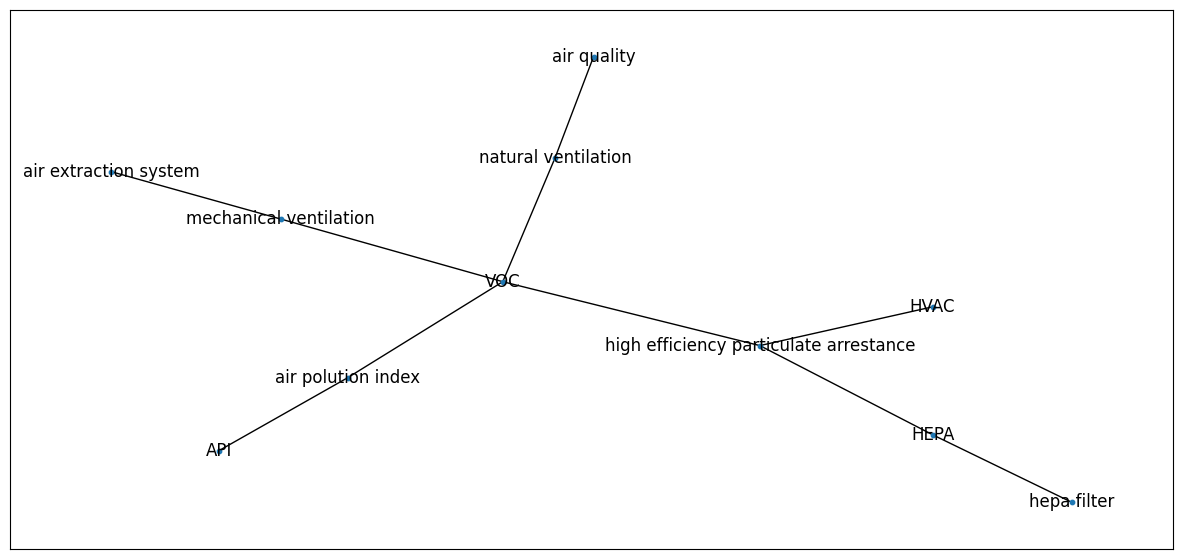

In [77]:
radius = 15
max_community = 15

focussed_graph = nx.ego_graph(network, node_of_interest, radius=radius)
community_of_interest = divide_into_communities(focussed_graph, 
                                                node_of_interest, 
                                                max_community_size=max_community)

# num_hops = 2
# nodes_with_x_hops_distance = nx.single_source_shortest_path_length(network, node_of_interest, cutoff=num_hops)
# nodes_with_x_hops_distance

### Node centrality

We'd like to see if similar grouping of terms occurs for spans, where e.g.;
* betweennes centrality (number of shortest paths that pass through the node) may help identify related groups of spans, e.g., `materials`, `systems` and so on
* other features that we could consider include the degree (number of edges for a node), and 'page rank' (importance of node based on importance of related nodes ~ e.g. has a definition)

In [46]:
span_rel_cntr = Counter()
for k, v in distance_dict.items():
    related_spans = [str(t) for t in v]
    span_rel_cntr[k] = len(related_spans)
    

In [40]:
span_rel_cntr.most_common(10)

In [50]:
# top 10 most connected nodes (not necessarily most central, as path distance may be long)
sorted(span_rel_cntr, key=span_rel_cntr.get, reverse=True)[:10]

['walled',
 'building',
 'buildings',
 'Buildings',
 'wall',
 'unpleasant',
 'area',
 'walls',
 'floor',
 'spaces']

**Compute the clustering coefficients for the nodes in the networks**

In graph theory, clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks (such as social networks) nodes tend to create tightly knit groups characterized by a relatively high density of ties; this likelihood tends to be greater than the average probability of a tie randomly established between two nodes (source; Wikipedia). 

In [97]:
# slow algorithm, we'll use an approximation based on k=256 nodes 
clustering = nx.betweenness_centrality(network, k=256) 
len(clustering)

6724

* Higher values are more connected

In [128]:
highly_connected_nodes = [n for n, bc in clustering.items() if bc > 1e-02]

In [129]:
len(highly_connected_nodes)

15

In [130]:
print("top 20 spans that are highly connected examples")
highly_connected_nodes[:20]
    

top 20 spans that are highly connected examples


['building',
 'buildings',
 'area',
 'walls',
 'floor',
 'roof',
 'deposition',
 'unpleasant',
 'wall',
 'walled',
 'heating',
 'fire',
 'pipe',
 'ventilation',
 'canton of']

Community [1] of size 15, top 10 spans by degree:
0: heating [64]
1: heat [45]
2: heated [43]
3: heat sources [12]
4: heating cooling [12]
5: furnace [10]
6: heat recovery [10]
7: heat gain [9]
8: heat alarm [8]
9: heat alarms [7]


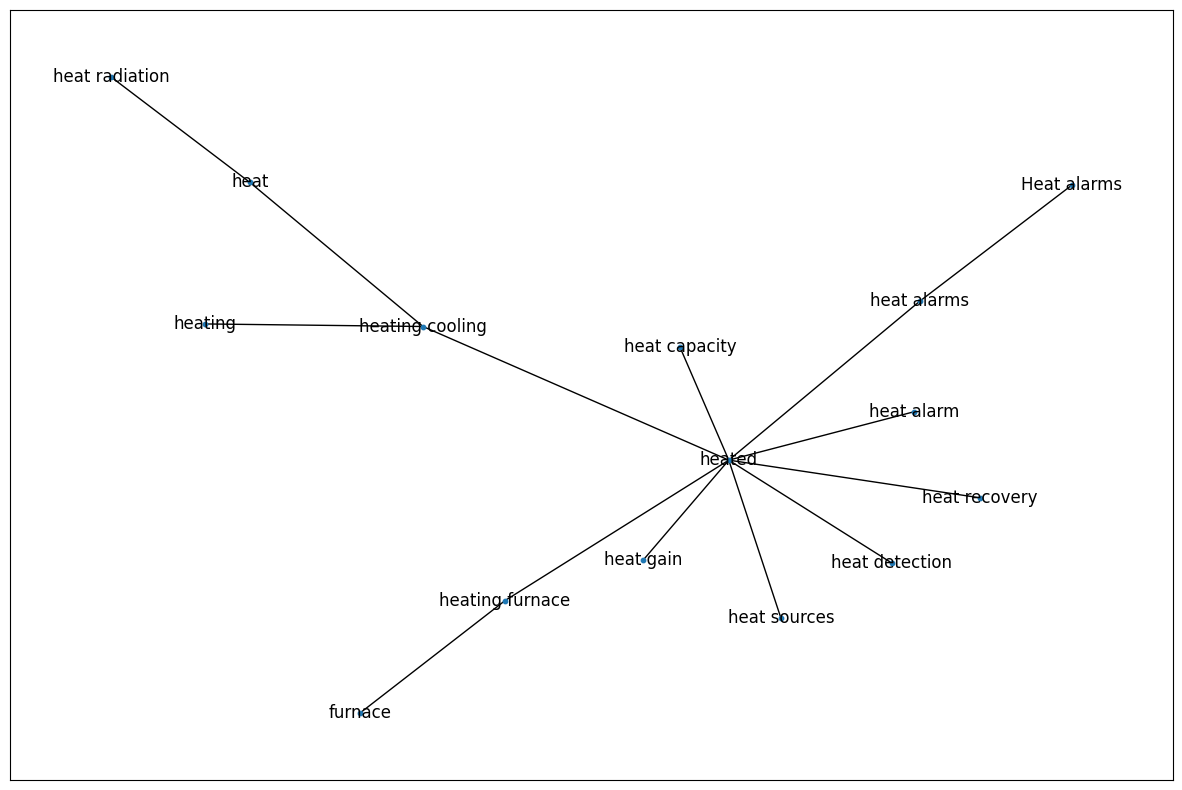

In [136]:
node_of_interest = 'heating'
radius = 10
max_community = 20

focussed_graph = nx.ego_graph(network, node_of_interest, radius=radius)
community_of_interest = divide_into_communities(focussed_graph, 
                                                node_of_interest, 
                                                max_community_size=max_community)

# num_hops = 2
# nodes_with_x_hops_distance = nx.single_source_shortest_path_length(network, node_of_interest, cutoff=num_hops)
# nodes_with_x_hops_distance

* We could also consider checking shortest paths to identify how terms are related, e.g., determine spans that connect the concepts `fire doorset` and `protected corridor`

In [132]:
term_A = 'fire doorset'
term_B = 'protected corridor'
nx.shortest_path(network, source=term_A, target=term_B, 
                 weight=None, method='dijkstra')

['fire doorset', 'secure doorset', 'clear access zone', 'protected corridor']

In [133]:
term_A = 'rockwool'
term_B = 'mineral wool'
nx.shortest_path(network, source=term_A, target=term_B, 
                 weight=None, method='dijkstra')

['rockwool',
 'rockwool insulation',
 'insulant',
 'matting insulation',
 'mineral wool']